# Installation & Import Dependencies

In [3]:
!pip install mediapipe opencv-python matplotlib pandas scikit-learn

In [4]:
import cv2
import math
from time import time
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

# Determining Joints

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

In [5]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

# Pose detection from an Image

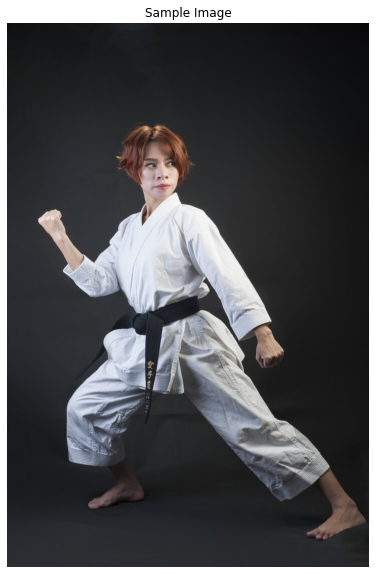

In [6]:
# Reading an image from the specified path.
sample_img = cv2.imread('media/sample.jpg')

# Specifying a size of the figure.
plt.figure(figsize = [10, 10])

# Displaying the sample image, also converting BGR to RGB for display. 
plt.title("Sample Image");plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [7]:
# Performing pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Checking if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):
        
        # Displaying the founded normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.42638272047042847
y: 0.28251832723617554
z: -0.567802369594574
visibility: 1.0

LEFT_EYE_INNER:
x: 0.43525373935699463
y: 0.2628730535507202
z: -0.5315181612968445
visibility: 0.9999998807907104



In [8]:
# Retrieving the height and width of the sample image.
image_height, image_width, _ = sample_img.shape

if results.pose_landmarks:
    
    for i in range(2):
        
        # Displaying the founded landmarks after converting them into their original scale.
        print(f'{mp_pose.PoseLandmark(i).name}:') 
        print(f'x: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
        print(f'y: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_height}')
        print(f'z: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')
        print(f'visibility: {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].visibility}\n')

NOSE:
x: 306.56917601823807
y: 305.1197934150696
z: -408.2499037384987
visibility: 1.0

LEFT_EYE_INNER:
x: 312.94743859767914
y: 283.90289783477783
z: -382.1615579724312
visibility: 0.9999998807907104



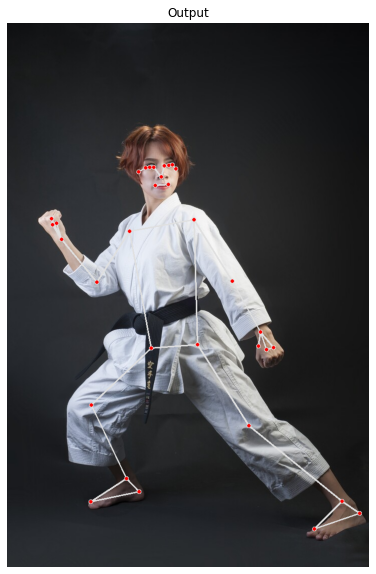

In [9]:
# Creating a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

if results.pose_landmarks:
    
    # Drawing Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specifying a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Displaying the output image with the landmarks drawn, also converting BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

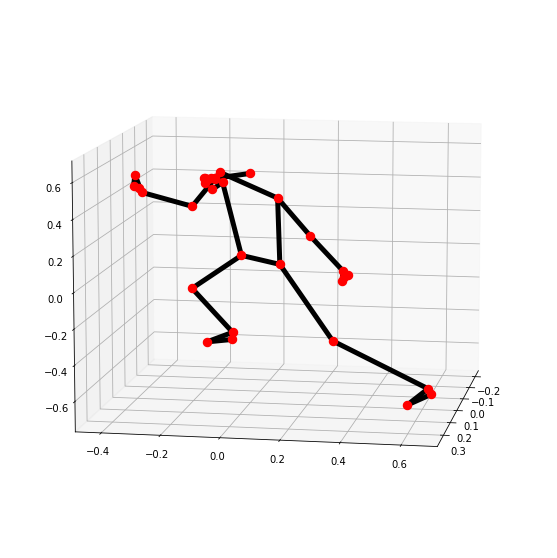

In [10]:
# Plotting Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [11]:
def detectPose(image, pose, display=True):

    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(imageRGB)
    
    height, width, _ = image.shape
    
    landmarks = []
    
    if results.pose_landmarks:
    
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    if display:
        
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    else:
        
        return output_image, landmarks

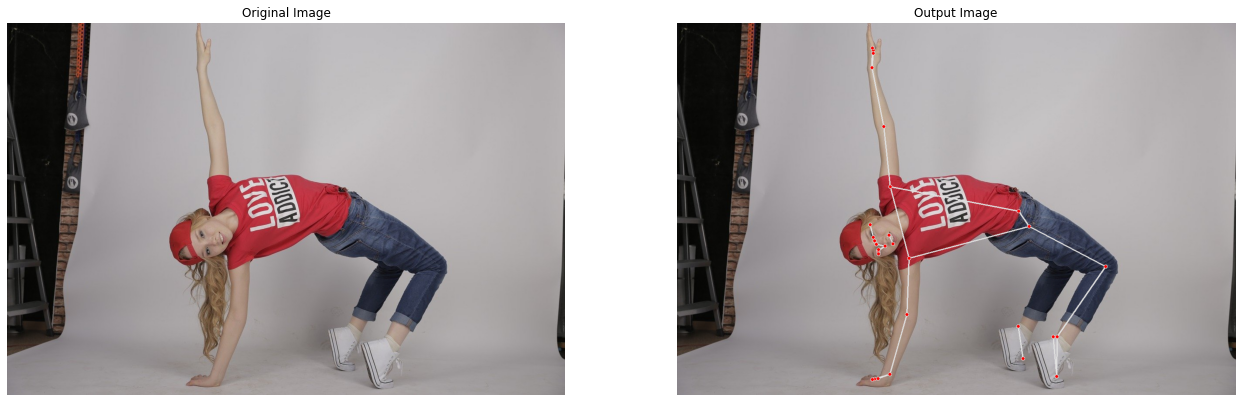

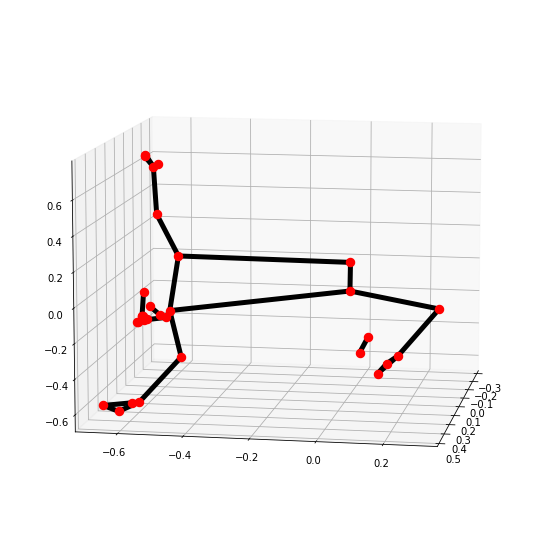

In [12]:
# Reading another sample image and performing pose detection on it.
image = cv2.imread('media/sample2.jpg')
detectPose(image, pose, display=True)

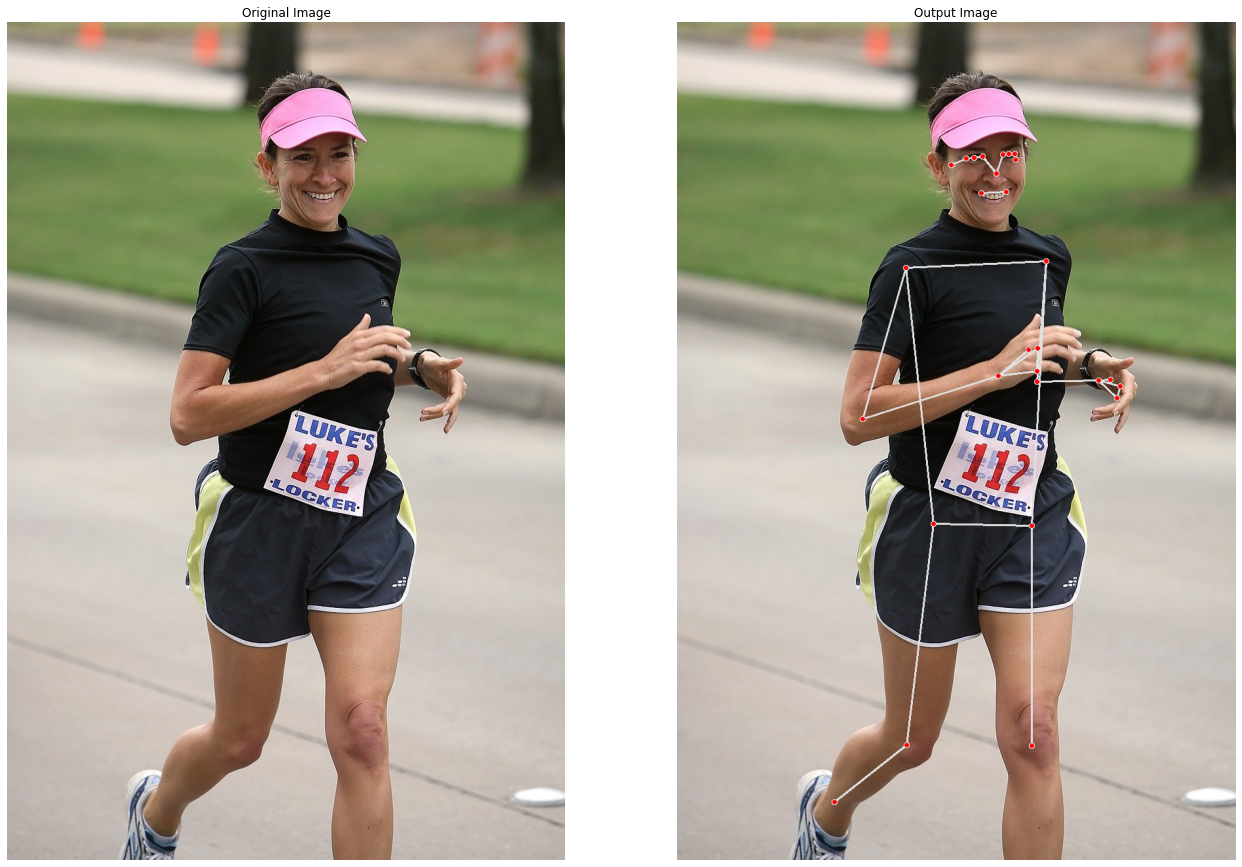

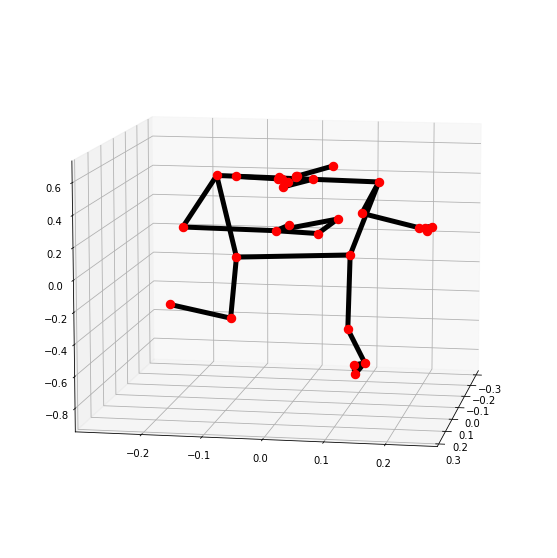

In [13]:
# Reading another sample image and performing pose detection on it.
image = cv2.imread('media/sample3.jpg')
detectPose(image, pose, display=True)

# Pose detection from a Video

In [14]:
def detectVideoPose(video):
    pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

    # Create named window for resizing purposes
    cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)

#     video = cv2.VideoCapture('media/running.mp4')

    # Set video camera size
    video.set(3,1280)
    video.set(4,960)

    # Initialize a variable to store the time of the previous frame.
    time1 = 0

    # Iterate until the video is accessed successfully.
    while video.isOpened():

        # Read a frame.
        ok, frame = video.read()

        # Check if frame is not read properly.
        if not ok:
            # Break the loop.
            break

        # Flip the frame horizontally for natural (selfie-view) visualization.
        frame = cv2.flip(frame, 1)

        # Get the width and height of the frame
        frame_height, frame_width, _ =  frame.shape

        # Resize the frame while keeping the aspect ratio.
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))

        # Perform Pose landmark detection.
        frame, _ = detectPose(frame, pose_video, display=False)

        # Set the time for this frame to the current time.
        time2 = time()

        # Check if the difference between the previous and this frame time > 0 to avoid division by zero.
        if (time2 - time1) > 0:

            # Calculate the number of frames per second.
            frames_per_second = 1.0 / (time2 - time1)

            # Write the calculated number of frames per second on the frame. 
            cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)

        # Update the previous frame time to this frame time.
        # As this frame will become previous frame in next iteration.
        time1 = time2

        # Display the frame.
        cv2.imshow('Pose Detection', frame)

        # Wait until a key is pressed.
        # Retreive the ASCII code of the key pressed
        k = cv2.waitKey(1) & 0xFF

        # Check if 'ESC' is pressed.
        if(k == 27):

            # Break the loop.
            break

    # Release the VideoCapture object.
    video.release()

    # Close the windows.
    cv2.destroyAllWindows()

In [70]:
video = cv2.VideoCapture('media/running.mp4')
detectVideoPose(video)

In [71]:
video = cv2.VideoCapture('media/exercising.mp4')
detectVideoPose(video)

### Analysis of angles

In [15]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [16]:
# Calculate the angle between the three landmarks.
angle = calculate_angle((558, 326, 0), (642, 333, 0), (718, 321, 0))

# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 166.2637316943774


# Pose Classifications

In [17]:
def classifyPose(landmarks, output_image, display=False):
    
    label = 'Unknown Pose'

    color = (0, 0, 255)

    # Getting the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Getting the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Getting the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Getting the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Getting the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Getting the angle between the right hip, knee and ankle points 
    right_knee_angle = calculate_angle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    

    # Checking if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle > 165 and right_elbow_angle < 195:

        # Checking if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:

    # Checking if it is the warrior II pose
            # Checking if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:

                # Checking if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:

                    label = 'Warrior II Pose' 
                        
    
    # Checking if it is the T pose.
            # Checking if both legs are straight
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:

                label = 'T Pose'


    if label != 'Unknown Pose':
        
        color = (255, 0, 0)  
     
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    if display:
    
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        return output_image, label

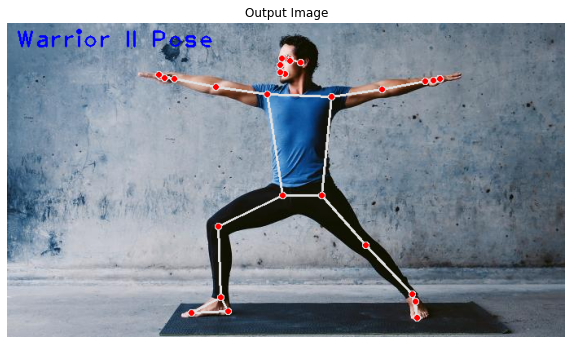

In [17]:
# Reading a sample image and performing pose classification on it.
image = cv2.imread('media/warriorIIpose1.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

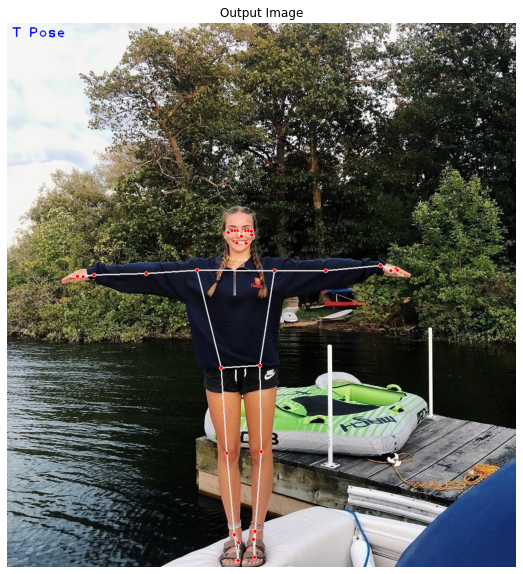

In [18]:
# Reading a sample image and performing pose classification on it.
image = cv2.imread('media/Tpose.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

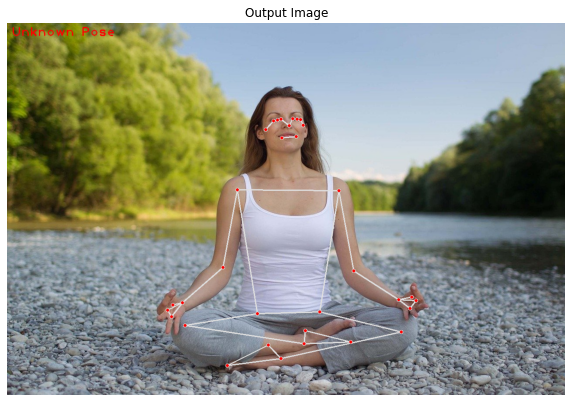

In [19]:
# Reading another sample image and performing pose classification on it.
image = cv2.imread('media/yoga.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    classifyPose(landmarks, output_image, display=True)

In [72]:
#user pose analysis

pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    
    ok, frame = camera_video.read()
    
    if not ok:
        
        continue
    
    frame = cv2.flip(frame, 1)
    
    frame_height, frame_width, _ =  frame.shape
    
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    if landmarks:
        
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    cv2.imshow('Pose Classification', frame)
    
    k = cv2.waitKey(1) & 0xFF
    
    if(k == 27):
        break

camera_video.release()
cv2.destroyAllWindows()

# Sports Analytics

In [73]:
def detectAndAnalyse(guided = True):
    
    measured_angle = []
    
    if guided == True:
        cap = cv2.VideoCapture('media/throwing.mp4')
    else:
        cap = cv2.VideoCapture(0)
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            try:
                landmarks = results.pose_landmarks.landmark

                #shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                #elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                #wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

                angle = calculate_angle(shoulder, elbow, wrist)
                measured_angle.append(angle)

                cv2.putText(image, str(angle), 
                               tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA
                                    )

            except:
                pass

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2) 
                                     )               

            cv2.imshow('Pose Analysis', image)

            k = cv2.waitKey(1) & 0xFF
            if(k == 27):
                break

        cap.release()
        cv2.destroyAllWindows()
    
    return measured_angle
    

In [74]:
#store guide pose analysis
guide_measurement = detectAndAnalyse(True)
guide_measurement = guide_measurement[:50]
print(guide_measurement)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
# user pose analysis
user_measurement = detectAndAnalyse(False)
user_measurement = user_measurement[:50]
print(user_measurement)

In [ ]:
#printing the difference & analysis
for i in range(len(user_measurement)):
    print(guide_measurement[i] - user_measurement[i])

# Train the model

In [21]:
import csv
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [22]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [23]:
mp_holistic = mp.solutions.holistic

In [36]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        results = holistic.process(image)
        
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
                        
        cv2.imshow('Pose Classification', image)

        k = cv2.waitKey(10) & 0xFF
        if k == 27:
            break

cap.release()
cv2.destroyAllWindows()

In [37]:
num_coords = len(results.pose_landmarks.landmark)
num_coords

33

In [38]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'visibility{}'.format(val)]

In [39]:
with open('coords.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

PermissionError: [Errno 13] Permission denied: 'coords.csv'

In [34]:
class_name = "Six"

In [35]:
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        results = holistic.process(image)

        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks on the image
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

        try:
            # Extract pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Insert class name to the beginning of the row
            pose_row.insert(0, class_name)
            
            # Write the row to the CSV file
            with open('coords.csv', mode='a', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(pose_row) 
            
        except Exception as e:
            print("An error occurred:", e)
                        
        cv2.imshow('Pose classification', image)

        k = cv2.waitKey(10) & 0xFF
        if k == 27:
            break


cap.release()
cv2.destroyAllWindows()

An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An er

An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error

An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneType' object has no attribute 'landmark'
An error occurred: 'NoneT

An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error occurred: [Errno 13] Permission denied: 'coords.csv'
An error

In [44]:
df = pd.read_csv('dataset.csv')

In [45]:
df.head()

class        x1        y1        z1  visibility1        x2        y2  \
0  T Pose  0.361663  0.275417 -0.358857     0.999940  0.365307  0.259656   
1  T Pose  0.360931  0.276106 -0.358856     0.999943  0.364360  0.259917   
2  T Pose  0.359547  0.276605 -0.364391     0.999945  0.363360  0.260306   
3  T Pose  0.359195  0.277152 -0.342389     0.999945  0.363017  0.260923   
4  T Pose  0.359138  0.277692 -0.344575     0.999945  0.362913  0.261644   

         z2  visibility2        x3  ...       z31  visibility31       x32  \
0 -0.366909     0.999713  0.369181  ...  0.318252      0.963646  0.444451   
1 -0.365928     0.999724  0.367797  ...  0.345015      0.961819  0.446097   
2 -0.370092     0.999734  0.366539  ...  0.340987      0.961112  0.447522   
3 -0.349377     0.999730  0.366027  ...  0.329706      0.959220  0.448547   
4 -0.352356     0.999728  0.365859  ...  0.339565      0.958324  0.449903   

        y32       z32  visibility32       x33       y33       z33  \
0  0.872094  0.071788      0.992445  0.338680  0.878802  0.192471   
1  0.872321  0.175524      0.992297  0.341326  0.878800  0.219876   
2  0.874016  0.170432      0.992262  0.341594  0.879684  0.211995   
3  0.874877  0.165043      0.992013  0.342480  0.880612  0.202286   
4  0.875892  0.145308      0.992002  0.342843  0.881204  0.211961   

   visibility33  
0      0.995155  
1      0.994983  
2      0.994935  
3      0.994747  
4      0.994654  

[5 rows x 133 columns]

In [46]:
df.tail()

class        x1        y1        z1  visibility1        x2        y2  \
1200  No Ball  0.783127  0.200994 -0.600419     0.973440  0.796298  0.156582   
1201  No Ball  0.782003  0.204648 -0.606712     0.972851  0.794199  0.159479   
1202  No Ball  0.781960  0.203821 -0.640586     0.974050  0.794355  0.159044   
1203  No Ball  0.781910  0.204379 -0.632884     0.975066  0.794249  0.159883   
1204  No Ball  0.781834  0.200725 -0.575554     0.976848  0.794239  0.158108   

            z2  visibility2        x3  ...       z31  visibility31       x32  \
1200 -0.620300     0.940341  0.807079  ...  1.078815      0.001659  0.931908   
1201 -0.626220     0.938347  0.804681  ...  1.059570      0.001616  0.937479   
1202 -0.651260     0.940895  0.804884  ...  1.046597      0.001615  0.941985   
1203 -0.644954     0.942942  0.804717  ...  1.036704      0.001555  0.941795   
1204 -0.584062     0.947023  0.804742  ...  1.081202      0.001519  0.941659   

           y32       z32  visibility32       x33       y33       z33  \
1200  2.065349  0.665750      0.000811  0.777115  2.107242  0.618095   
1201  2.057498  0.655128      0.000803  0.783327  2.097596  0.593928   
1202  2.054719  0.624209      0.000804  0.786578  2.094733  0.576667   
1203  2.055057  0.572526      0.000775  0.786335  2.096184  0.573276   
1204  2.055526  0.548692      0.000764  0.786497  2.097468  0.620830   

      visibility33  
1200      0.000757  
1201      0.000742  
1202      0.000751  
1203      0.000726  
1204      0.000724  

[5 rows x 133 columns]

In [47]:
df[df['class']=='Wide Ball']

class        x1        y1        z1  visibility1        x2        y2  \
1036  No Ball  0.786975  0.176044 -0.613193     0.989013  0.793713  0.139486   
1037  No Ball  0.786195  0.182137 -0.602093     0.986770  0.793013  0.142775   
1038  No Ball  0.786267  0.183214 -0.728526     0.986471  0.794115  0.143162   
1039  No Ball  0.787348  0.185830 -0.803029     0.985837  0.796275  0.144617   
1040  No Ball  0.787810  0.186421 -0.764874     0.985461  0.797726  0.145055   
...       ...       ...       ...       ...          ...       ...       ...   
1200  No Ball  0.783127  0.200994 -0.600419     0.973440  0.796298  0.156582   
1201  No Ball  0.782003  0.204648 -0.606712     0.972851  0.794199  0.159479   
1202  No Ball  0.781960  0.203821 -0.640586     0.974050  0.794355  0.159044   
1203  No Ball  0.781910  0.204379 -0.632884     0.975066  0.794249  0.159883   
1204  No Ball  0.781834  0.200725 -0.575554     0.976848  0.794239  0.158108   

            z2  visibility2        x3  ...       z31  visibility31       x32  \
1036 -0.600623     0.980917  0.801459  ...  0.618535      0.011904  0.933084   
1037 -0.593876     0.977940  0.800719  ...  0.515450      0.012442  0.929355   
1038 -0.706158     0.977016  0.802811  ...  0.527281      0.012560  0.927781   
1039 -0.775912     0.975490  0.805426  ...  0.507041      0.012225  0.933660   
1040 -0.745384     0.974379  0.807110  ...  0.515104      0.012015  0.931523   
...        ...          ...       ...  ...       ...           ...       ...   
1200 -0.620300     0.940341  0.807079  ...  1.078815      0.001659  0.931908   
1201 -0.626220     0.938347  0.804681  ...  1.059570      0.001616  0.937479   
1202 -0.651260     0.940895  0.804884  ...  1.046597      0.001615  0.941985   
1203 -0.644954     0.942942  0.804717  ...  1.036704      0.001555  0.941795   
1204 -0.584062     0.947023  0.804742  ...  1.081202      0.001519  0.941659   

           y32       z32  visibility32       x33       y33       z33  \
1036  2.139590  0.241177      0.004154  0.774744  2.170261  0.130829   
1037  2.098385  0.197496      0.004252  0.772735  2.126699  0.092136   
1038  2.067217  0.223201      0.004419  0.771884  2.090103  0.096890   
1039  2.050518  0.301547      0.004411  0.778721  2.079378  0.080081   
1040  2.056213  0.295670      0.004403  0.778370  2.082095  0.085888   
...        ...       ...           ...       ...       ...       ...   
1200  2.065349  0.665750      0.000811  0.777115  2.107242  0.618095   
1201  2.057498  0.655128      0.000803  0.783327  2.097596  0.593928   
1202  2.054719  0.624209      0.000804  0.786578  2.094733  0.576667   
1203  2.055057  0.572526      0.000775  0.786335  2.096184  0.573276   
1204  2.055526  0.548692      0.000764  0.786497  2.097468  0.620830   

      visibility33  
1036      0.005708  
1037      0.005792  
1038      0.005853  
1039      0.005718  
1040      0.005579  
...            ...  
1200      0.000757  
1201      0.000742  
1202      0.000751  
1203      0.000726  
1204      0.000724  

[169 rows x 133 columns]

In [48]:
X = df.drop('class', axis=1)
y = df['class']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [50]:
y_test

398          Victory
716     Warrior Pose
248          Victory
1039         No Ball
1037         No Ball
            ...     
817        Yoga Pose
518          Victory
1016       Yoga Pose
1032       Yoga Pose
905        Yoga Pose
Name: class, Length: 362, dtype: object

In [51]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

In [52]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [53]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

In [54]:
fit_models['rc'].predict(X_test)

array(['Victory', 'Warrior Pose', 'Victory', 'No Ball', 'No Ball',
       'Warrior Pose', 'Yoga Pose', 'Yoga Pose', 'Yoga Pose', 'No Ball',
       'Yoga Pose', 'No Ball', 'No Ball', 'Yoga Pose', 'No Ball',
       'Victory', 'T Pose', 'Yoga Pose', 'T Pose', 'Victory', 'Victory',
       'Victory', 'Yoga Pose', 'Yoga Pose', 'Victory', 'Victory',
       'Victory', 'No Ball', 'Yoga Pose', 'Yoga Pose', 'No Ball',
       'Yoga Pose', 'Yoga Pose', 'Warrior Pose', 'Warrior Pose',
       'Victory', 'Victory', 'Yoga Pose', 'Warrior Pose', 'Victory',
       'Yoga Pose', 'Victory', 'Victory', 'T Pose', 'No Ball', 'T Pose',
       'Yoga Pose', 'T Pose', 'Warrior Pose', 'T Pose', 'Warrior Pose',
       'Victory', 'Yoga Pose', 'No Ball', 'Warrior Pose', 'No Ball',
       'Warrior Pose', 'T Pose', 'T Pose', 'Warrior Pose', 'Yoga Pose',
       'Victory', 'T Pose', 'No Ball', 'T Pose', 'Yoga Pose', 'Yoga Pose',
       'Yoga Pose', 'Warrior Pose', 'Warrior Pose', 'Warrior Pose',
       'Victory', 'Victory

In [55]:
from sklearn.metrics import accuracy_score 
import pickle 

In [56]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 1.0
rc 1.0
rf 1.0
gb 1.0


In [57]:
fit_models['rf'].predict(X_test)

array(['Victory', 'Warrior Pose', 'Victory', 'No Ball', 'No Ball',
       'Warrior Pose', 'Yoga Pose', 'Yoga Pose', 'Yoga Pose', 'No Ball',
       'Yoga Pose', 'No Ball', 'No Ball', 'Yoga Pose', 'No Ball',
       'Victory', 'T Pose', 'Yoga Pose', 'T Pose', 'Victory', 'Victory',
       'Victory', 'Yoga Pose', 'Yoga Pose', 'Victory', 'Victory',
       'Victory', 'No Ball', 'Yoga Pose', 'Yoga Pose', 'No Ball',
       'Yoga Pose', 'Yoga Pose', 'Warrior Pose', 'Warrior Pose',
       'Victory', 'Victory', 'Yoga Pose', 'Warrior Pose', 'Victory',
       'Yoga Pose', 'Victory', 'Victory', 'T Pose', 'No Ball', 'T Pose',
       'Yoga Pose', 'T Pose', 'Warrior Pose', 'T Pose', 'Warrior Pose',
       'Victory', 'Yoga Pose', 'No Ball', 'Warrior Pose', 'No Ball',
       'Warrior Pose', 'T Pose', 'T Pose', 'Warrior Pose', 'Yoga Pose',
       'Victory', 'T Pose', 'No Ball', 'T Pose', 'Yoga Pose', 'Yoga Pose',
       'Yoga Pose', 'Warrior Pose', 'Warrior Pose', 'Warrior Pose',
       'Victory', 'Victory

In [58]:
y_test

398          Victory
716     Warrior Pose
248          Victory
1039         No Ball
1037         No Ball
            ...     
817        Yoga Pose
518          Victory
1016       Yoga Pose
1032       Yoga Pose
905        Yoga Pose
Name: class, Length: 362, dtype: object

In [59]:
with open('pose_estimation.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

In [68]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Suppress the warning
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        results = holistic.process(image)

        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )

        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )

        try:
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            row = pose_row
            
            X = pd.DataFrame([row])
            pose_estimation_class = model.predict(X)[0]
            pose_estimation_prob = model.predict_proba(X)[0]
            print(pose_estimation_class, pose_estimation_prob)
            
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW.value].x, 
                                 results.pose_landmarks.landmark[PoseLandmark.LEFT_ELBOW.value].x))
                        , [640,480]).astype(int))
            
            cv2.rectangle(image, 
                          (coords[0], coords[1]+5), 
                          (coords[0]+len(pose_estimation_class)*20, coords[1]-30), 
                          (245, 117, 16), -1)
            cv2.putText(image, pose_estimation_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, pose_estimation_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(pose_estimation_prob[np.argmax(pose_estimation_prob)],2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except:
            pass
                        
        cv2.imshow('Pose estimation', image)

        k = cv2.waitKey(10) & 0xFF
        if k == 27:
            break

cap.release()
cv2.destroyAllWindows()


No Ball [9.99998721e-01 9.59266630e-08 1.17150043e-07 9.79192228e-08
 9.68422489e-07]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520645e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520645e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520645e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520645e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520645e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520560e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520560e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20520560e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20519713e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 1.20519934e-07
 1.19195087e-06]
No Ball [9.99998425e-01 1.18068168e-07 1.44190265e-07 